In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
import torch.nn.functional as F
from torch_geometric.nn import GATConv, TopKPooling, global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn import GATConv
import torch_geometric
from pysal.lib import weights
from scipy import sparse
from scipy.sparse import eye
import matplotlib.pyplot as plt
import random
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
data = gpd.read_file("/content/drive/My Drive/SFL/election.geojson")
data = data.to_crs("+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

# input labels
y = data['pct_gop_16'].values

# input independent variables
X_vars = ['AGE135214','AGE775214','POP815213',
          'SEX255214','RHI125214','POP715213','EDU635213','EDU685213',
          'LFE305213','HSG445213']
X = data[X_vars].values

X_names = ['AGE_U5','AGE_O65','LO5', 'Female_pct','White_pct','LH1','EDU_H25','EDU_B25','MTW_16','HR']

data['X'] = data['geometry'].centroid.x
data['Y'] = data['geometry'].centroid.y
coords = data[['X', 'Y']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

features = torch.FloatTensor(X_scaled).to(device)
labels = torch.FloatTensor(y).to(device)

In [ ]:
def make_sym_matrix_boolean_sum(matrix):
    return matrix + matrix.T

def renormalized_trick_mx(matrix):
    I = np.eye(matrix.shape[0])
    D = np.diag(np.sum(matrix, axis=1))
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diagonal(D)))
    return D_inv_sqrt @ (matrix + I) @ D_inv_sqrt

def renormalized_trick_laplacian(matrix):
    I = np.eye(matrix.shape[0])
    return I - matrix

def calculate_weighted_similarity(X, sigma_values, weights):
    u = X[:, np.newaxis, :]
    v = X[np.newaxis, :, :]
    sq_diff = (u - v) ** 2
    E_i = np.exp(-((sq_diff) / (2 * (sigma_values))))
    weighted_similarity = np.average(E_i, axis=2, weights=weights)
    return weighted_similarity

# Identify the neigborhoods of observations, bandwith calculated by GWR, Queen rule, Rook rule, KNN
# gwr_selector = Sel_BW(coords, y.reshape(-1,1), X_scaled)
# gwr_k = gwr_selector.search(search_method='golden_section', criterion='AICc')
# knn=weights.KNN.from_dataframe(data,geom_col='geometry',k=gwr_k)
knn=weights.KNN.from_dataframe(data,geom_col='geometry',k=30)
A_20nn_sym = make_sym_matrix_boolean_sum(knn.full()[0])
A_tilde_20nn_sym = renormalized_trick_mx(A_20nn_sym)

# Calculate spatial similarity as edge weights of GAT model
sigma_values = np.var(X, axis=0)
weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
similarity_matrix1 = calculate_weighted_similarity(X, sigma_values, weights)

weighted_adj = np.zeros_like(A_20nn_sym, dtype=np.float32)
for i in range(A_20nn_sym.shape[0]):
    neighbors = np.where(A_20nn_sym[i] > 0)[0]
    for neighbor in neighbors:
        weighted_adj[i, neighbor] = similarity_matrix1[i, neighbor]

weighted_adj_tensor = torch.FloatTensor(weighted_adj).to(device)

In [ ]:
edge_index, edge_weight = torch_geometric.utils.dense_to_sparse(weighted_adj_tensor)
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)

In [ ]:
class CausalGAT(nn.Module):
    def __init__(self, f_in, n_classes, hidden=[40], heads=20):
        super(CausalGAT, self).__init__()
        self.conv_causal = GATConv(f_in, hidden[0], heads=heads, edge_dim=1, concat=True)
        self.conv_trivial = GATConv(f_in, hidden[0], heads=heads, edge_dim=1, concat=True)
        self.bn_causal = BatchNorm(hidden[0] * heads)
        self.bn_trivial = BatchNorm(hidden[0] * heads)
        self.fc_causal = nn.Linear(hidden[0] * heads, n_classes)
        self.fc_trivial = nn.Linear(hidden[0] * heads, n_classes)
        self.linear_causal = nn.Linear(hidden[0] * heads, f_in)
        self.linear_trivial = nn.Linear(hidden[0] * heads, f_in)
        self.combined_conv = GATConv(hidden[0] * heads, n_classes, heads=heads, edge_dim=1, concat=False)

    def forward(self, x, edge_index, edge_weight):
        x_causal = F.elu(self.conv_causal(x, edge_index, edge_weight))
        x_trivial = F.elu(self.conv_trivial(x, edge_index, edge_weight))

        x_causal = self.bn_causal(x_causal)
        x_trivial = self.bn_trivial(x_trivial)

        x_causal_mean = self.linear_causal(x_causal)
        x_trivial_mean = self.linear_trivial(x_trivial)

        x_combined = x_causal + x_trivial
        x_out = self.combined_conv(x_combined, edge_index, edge_weight)

        return x_out, x_causal_mean, x_trivial_mean

In [ ]:
def train_model(model, features, edge_index, edge_weight, labels, epochs=2000, lr=1e-3, weight_decay=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output, x_causal, x_trivial = model(features, edge_index, edge_weight)

        regression_loss = F.mse_loss(output.squeeze(), labels)
        causal_loss = F.mse_loss(x_causal.mean(dim=1), labels.squeeze())
        trivial_loss = F.mse_loss(x_trivial.mean(dim=1), labels.squeeze())

        # loss = regression_loss + 1.0 * causal_loss
        loss = regression_loss + 1.0 * (causal_loss + trivial_loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f},  Causal Loss: {causal_loss.item():.4f}')

    return model

causal_model = CausalGAT(f_in=features.shape[1], n_classes=1, hidden=[40], heads=20).to(device)
trained_causal_model = train_model(causal_model, features, edge_index, edge_weight, labels, epochs=2000, lr=1e-3)

Epoch 100/2000, Loss: 0.0274,  Causal Loss: 0.0073
Epoch 200/2000, Loss: 0.0183,  Causal Loss: 0.0049
Epoch 300/2000, Loss: 0.0156,  Causal Loss: 0.0040
Epoch 400/2000, Loss: 0.0151,  Causal Loss: 0.0039
Epoch 500/2000, Loss: 0.0173,  Causal Loss: 0.0046
Epoch 600/2000, Loss: 0.0140,  Causal Loss: 0.0037
Epoch 700/2000, Loss: 0.0119,  Causal Loss: 0.0032
Epoch 800/2000, Loss: 0.0116,  Causal Loss: 0.0032
Epoch 900/2000, Loss: 0.0108,  Causal Loss: 0.0030
Epoch 1000/2000, Loss: 0.0107,  Causal Loss: 0.0030
Epoch 1100/2000, Loss: 0.0105,  Causal Loss: 0.0030
Epoch 1200/2000, Loss: 0.0099,  Causal Loss: 0.0029
Epoch 1300/2000, Loss: 0.0118,  Causal Loss: 0.0034
Epoch 1400/2000, Loss: 0.0092,  Causal Loss: 0.0028
Epoch 1500/2000, Loss: 0.0090,  Causal Loss: 0.0027
Epoch 1600/2000, Loss: 0.0087,  Causal Loss: 0.0027
Epoch 1700/2000, Loss: 0.0086,  Causal Loss: 0.0027
Epoch 1800/2000, Loss: 0.0083,  Causal Loss: 0.0026
Epoch 1900/2000, Loss: 0.0098,  Causal Loss: 0.0031
Epoch 2000/2000, Loss

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def evaluate_causal_model(model, features, edge_index, edge_weight, labels):
    model.eval()
    with torch.no_grad():
        predictions, _, _ = model(features, edge_index, edge_weight)
        predictions = predictions.squeeze()
        mse = F.mse_loss(predictions, labels)
        rmse = torch.sqrt(mse)
        mae = F.l1_loss(predictions, labels)
        y_true = labels.cpu().numpy()
        y_pred = predictions.cpu().numpy()
        mape = mean_absolute_percentage_error(y_true, y_pred)
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
    return predictions, mse, rmse, mae, mape, r2

causal_predictions, mse, rmse, mae, mape, r2 = evaluate_causal_model(trained_causal_model, features, edge_index, edge_weight, labels)
print(f'Test MSE: {mse.item():.4f}')
print(f'Test RMSE: {rmse.item():.4f}')
print(f'Test MAE: {mae.item():.4f}')
print(f'Test MAPE: {mape:.4f}%')
print(f'Test R²: {r2:.4f}')

Test MSE: 0.0010
Test RMSE: 0.0315
Test MAE: 0.0249
Test MAPE: 4.5013%
Test R²: 0.9593


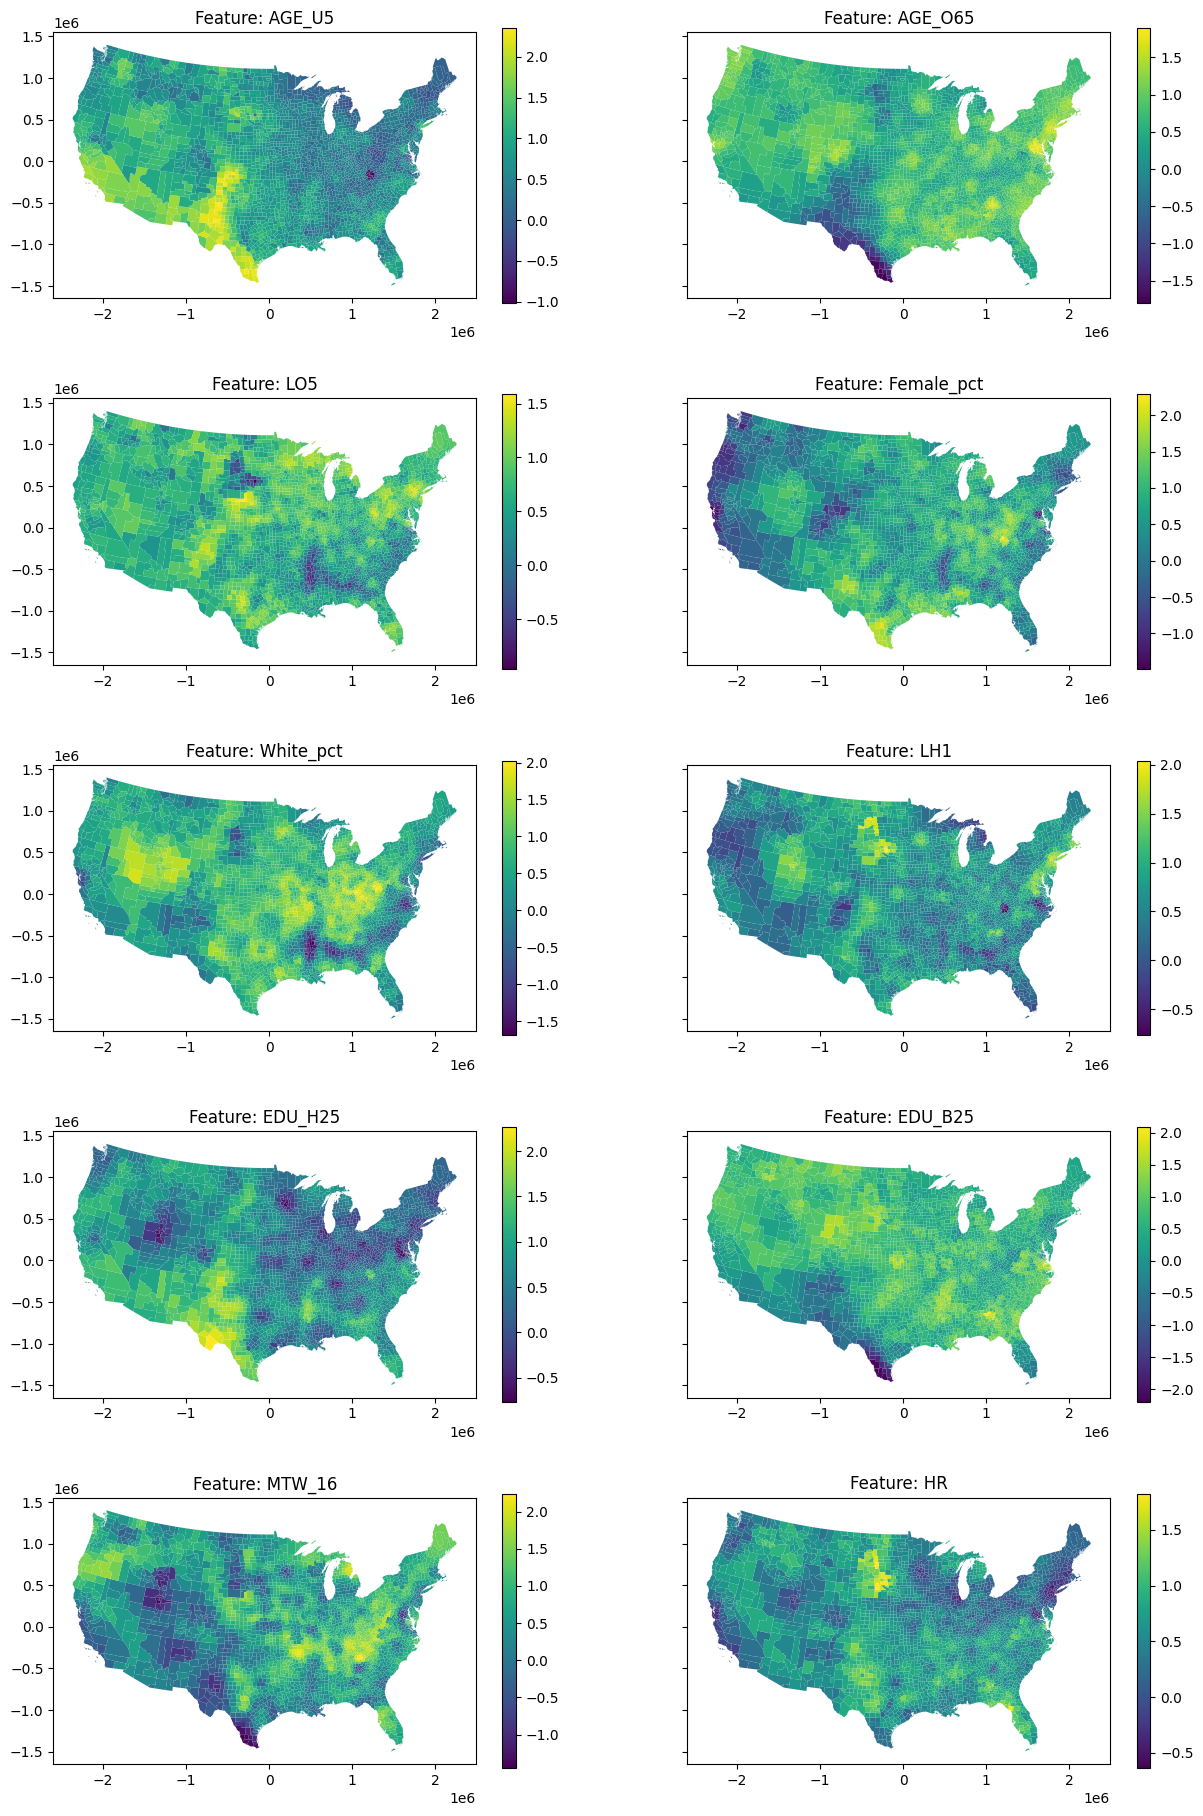

In [ ]:
def plot_causal_attention_maps(gdf, causal_attention_matrix, feature_names):
    num_features = causal_attention_matrix.shape[1]

    fig, axes = plt.subplots(5, 2, figsize=(15, 23), sharey=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_features:
            gdf['attention_score'] = causal_attention_matrix[:, i]

            gdf.plot(column='attention_score', ax=ax, legend=True, cmap='viridis', legend_kwds={'orientation': 'vertical','shrink': 0.9})
            ax.set_title(f'Feature: {feature_names[i]}')
        else:
            fig.delaxes(ax)

    # plt.tight_layout()
    # plt.show()

causal_attention_matrix = trained_causal_model(features, edge_index, edge_weight)[1].detach().cpu().numpy()
plot_causal_attention_maps(data, causal_attention_matrix, X_names)
plt.savefig('/picture/lcsm_e2.jpg', dpi=600)

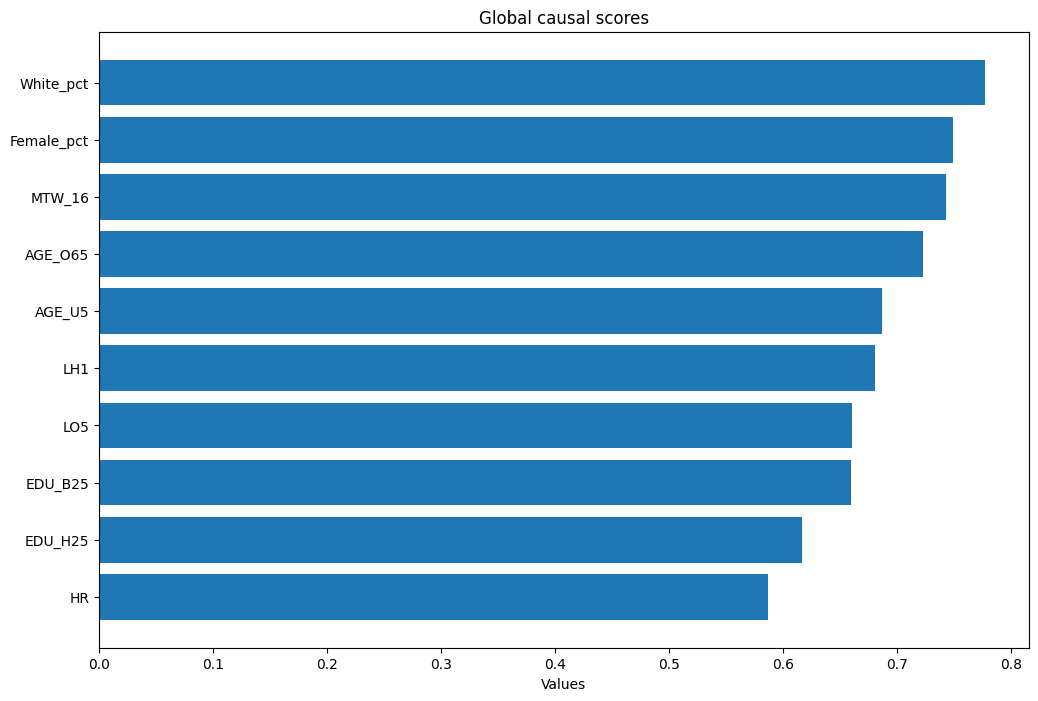

In [ ]:
def compute_global_feature_importance(causal_attention_matrix):
    global_importance = np.sum(np.abs(causal_attention_matrix), axis=0)
    return global_importance

global_feature_importance = compute_global_feature_importance(causal_attention_matrix)/causal_attention_matrix.shape[0]

def plot_global_feature_importance(feature_importance, feature_names):
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_feature_names = np.array(feature_names)[sorted_indices]

    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(sorted_feature_names))
    plt.barh(y_pos, sorted_importance, align='center')
    plt.yticks(y_pos, sorted_feature_names)
    plt.xlabel('Values')
    plt.title('Global causal scores')
    plt.gca().invert_yaxis()
    # plt.show()

plot_global_feature_importance(global_feature_importance, X_names)
plt.savefig('/picture/gcs_e.jpg', dpi=600)